# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
%pip install scikit-image

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.applications import mobilenet
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 64

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels    

def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # logic for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)   

def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 80, 80, 3]

def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))
    
def stepsperepoch(num_train_sequences,num_val_sequences,batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return (steps_per_epoch,validation_steps) 


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [11]:
# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 80, 80, 3]


In [12]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  datasets/Project_data/train ; batch size = 64
(64, 20, 80, 80, 3)
Source path =  datasets/Project_data/val ; batch size = 64
(64, 20, 80, 80, 3)


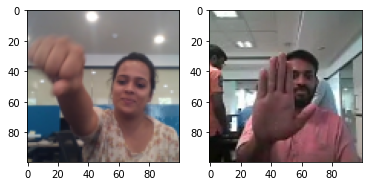

In [8]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[28,10,:,:,:])   
ax[1].imshow(sample_val_batch_data[40,10,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers



In [10]:
 #input_shape = (len(img_idx),image_width,image_height,3)

## Model : 1

In [14]:
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model = Sequential([
Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
MaxPooling3D(make3dFilter(2), padding='same'),
BatchNormalization(),

Conv3D(32, make3dFilter(3), activation='relu'),
MaxPooling3D(pool_size=(1,2,2), padding='same'),
BatchNormalization(),

Conv3D(64, make3dFilter(3), activation='relu'),
MaxPooling3D(pool_size=(1,2,2), padding='same'),
BatchNormalization(),

Flatten(),
Dense(128, activation='relu'),
BatchNormalization(),
Dropout(0.25),

Dense(64, activation='relu'),
BatchNormalization(),
Dropout(0.25),

Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 76, 76, 16)    6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 38, 38, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 38, 38, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 36, 36, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 18, 18, 32)    0         
 3D)                                                             
                                                        

2024-04-30 17:46:33.385413: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-30 17:46:33.385495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
train_generator = generator(train_path, train_doc, batch_size ,img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
model1_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 64
Epoch 1/20


2024-04-29 12:14:57.710467: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.5901 - categorical_accuracy: 0.4661 Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2024-04-2912_13_41.246072/model-00001-1.59009-0.46606-2.27846-0.26000.h5
11/11 [==============================] - 129s 12s/step - loss: 1.5901 - categorical_accuracy: 0.4661 - val_loss: 2.2785 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.9789 - categorical_accuracy: 0.6640
Epoch 00002: saving model to model_init_2024-04-2912_13_41.246072/model-00002-0.97889-0.66403-3.05694-0.23438.h5
11/11 [==============================] - 55s 5s/step - loss: 0.9789 - categorical_accuracy: 0.6640 - val_loss: 3.0569 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.0566 - categorical_accuracy: 0.6522
Epoch 00003: saving model to model_init_2024-04-2912_13_41.246072/model-0

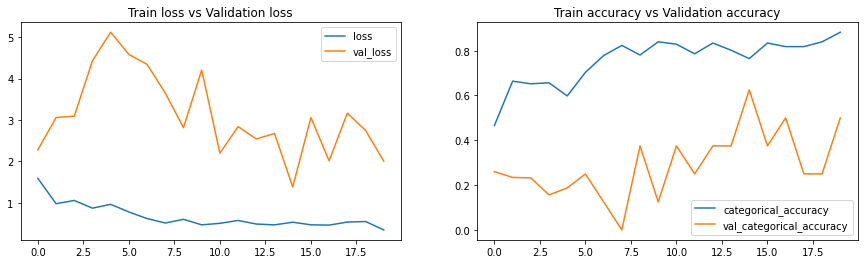

Max. Training Accuracy 0.8823529481887817
Max. Validaiton Accuracy 0.625


In [16]:
plotModelHistory(model1_history)

#### Model Type - CONV3D Model
#### Total params: 4,050,085
#### Training Accuracy - 0.88
#### Validation Accuracy - 0.50
#### Inference : Overfit Model, lets try to change the Frames and Epochs

## Model 2: Frames-15, Epochs-20

In [21]:
n_frames = 15
num_epochs = 20
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    #Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
   # Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 11, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 6, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 6, 48, 48, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 4, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 4, 23, 23, 32)    0         
 g3D)                                                            
                                                          

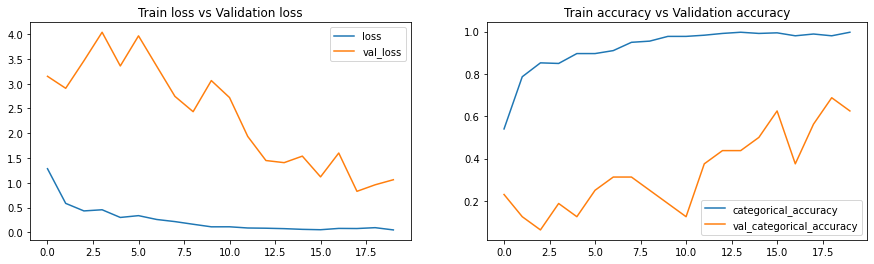

Max. Training Accuracy 0.9971988797187805
Max. Validaiton Accuracy 0.6875


In [22]:
plotModelHistory(model2_history)

#### Model Type - CONV3D Model
#### Total params: 2,067,621
#### Training Accuracy - 0.99
#### Validation Accuracy - 0.68
#### Inference : Overfit Model, lets try to change the Frames and Epochs

# Model 3: Frames-20, Epochs-20

In [24]:
n_frames = 20
num_epochs = 20
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model3 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
   # Dense(128, activation='relu'),
   # BatchNormalization(),
    #Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
   # Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 8, 48, 48, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 8, 48, 48, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_16 (Conv3D)          (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 6, 23, 23, 32)    0         
 g3D)                                                            
                                                          

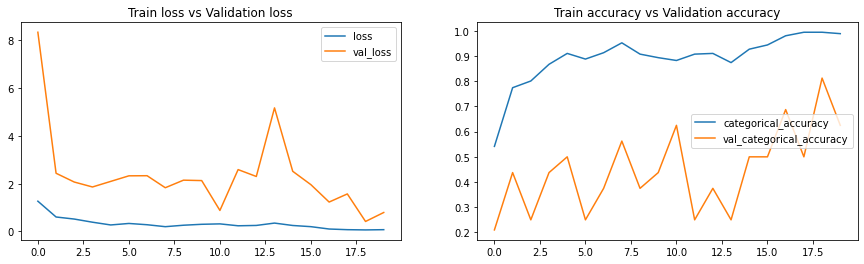

Max. Training Accuracy 0.994397759437561
Max. Validaiton Accuracy 0.8125


In [25]:
plotModelHistory(model3_history)

#### Model Type - CONV3D Model
#### Total params: 2,058,789
#### Training Accuracy - 0.99
#### Validation Accuracy - 0.81
#### Inference : Better accuracy then prev model, Here model is performing well on both training and validation 

# Model 4: Frames-15, Epocs-20, Layer Changes

In [45]:
n_frames = 15
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model4 = Sequential([
    Conv3D(16, make3dFilter(3), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),
    Dropout(0.25),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    #Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
   # Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

model4_history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 13, 98, 98, 16)    1312      
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 7, 49, 49, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_32 (Bat  (None, 7, 49, 49, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_22 (Conv3D)          (None, 5, 47, 47, 32)     13856     
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 5, 24, 24, 32)    0         
 g3D)                                                            
                                                          

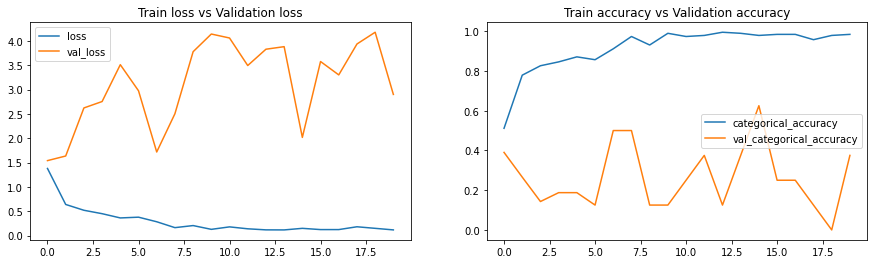

Max. Training Accuracy 0.9946523904800415
Max. Validaiton Accuracy 0.625


In [46]:
plotModelHistory(model4_history)

#### Model Type - CONV3D Model
#### Total params: 3,054,149
#### Training Accuracy - 0.99
#### Validation Accuracy - 0.62
#### Inference : Model is performing well on traing but quite less on validation data

# Model 5: Conv3D + Hyperparameter Tunning

In [24]:
n_frames = 30
num_epochs = 20
batch_size = 20

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model5 = Sequential([
    Conv3D(16, make3dFilter(3), activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2), padding='same'),
    

    Conv3D(32, make3dFilter(3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
      

    Conv3D(64, make3dFilter(2), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    
    
    Conv3D(128, make3dFilter(2), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
     

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
   # Dropout(0.25),

    Dense(256, activation='relu'),
    BatchNormalization(),
   # Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")

model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

model5_history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 28, 98, 98, 16)    1312      
                                                                 
 batch_normalization_28 (Bat  (None, 28, 98, 98, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 14, 49, 49, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 12, 47, 47, 32)    13856     
                                                                 
 batch_normalization_29 (Bat  (None, 12, 47, 47, 32)   128       
 chNormalization)                                                
                                                          

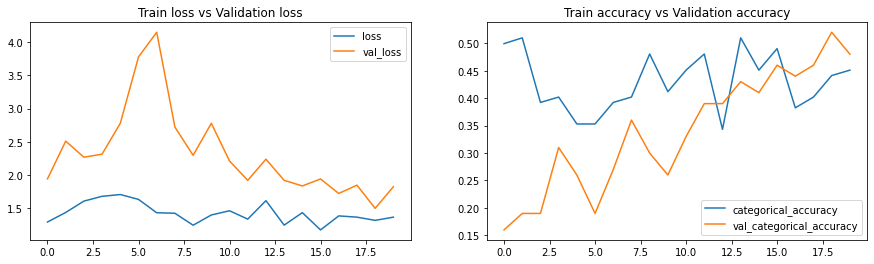

Max. Training Accuracy 0.5098039507865906
Max. Validaiton Accuracy 0.5199999809265137


In [25]:
plotModelHistory(model5_history)

#### Model Type - CONV3D + Hyperparameter Tunning
#### Total params: 724,037
#### Training Accuracy - 0.50
#### Validation Accuracy - 0.51
#### Inference : Adding more layers and doing hyperparameter not giving us good accuracy

# Model 6: Conv2D+LSTM

In [15]:
n_frames = 15
num_epochs = 20
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    #Dropout(0.2),

    Dense(256, activation='relu'),
    #Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 15, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 15, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 15, 50, 50, 32)  

2024-04-29 16:18:01.872740: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.2700 - categorical_accuracy: 0.4555Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2024-04-2916_16_41.720208/model-00001-1.27004-0.45551-1.56010-0.37000.h5
21/21 [==============================] - 96s 5s/step - loss: 1.2700 - categorical_accuracy: 0.4555 - val_loss: 1.5601 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.9485 - categorical_accuracy: 0.6190
Epoch 00002: saving model to model_init_2024-04-2916_16_41.720208/model-00002-0.94850-0.61905-1.75547-0.18750.h5
21/21 [==============================] - 59s 3s/step - loss: 0.9485 - categorical_accuracy: 0.6190 - val_loss: 1.7555 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.8823 - categorical_accuracy: 0.6581
Epoch 00003: saving model to model_init_2024-04-2916_16_41.720208/model-0000

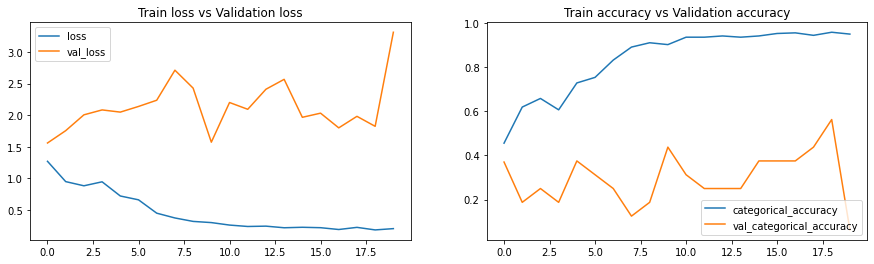

Max. Training Accuracy 0.9579831957817078
Max. Validaiton Accuracy 0.5625


In [17]:
plotModelHistory(model6_history)

#### Model Type - CONV2D + LSTM Model
#### Total params: 3,084,133
#### Training Accuracy - 0.95
#### Validation Accuracy - 0.56
#### Inference : Model is giving good accuracy on traing data but not at all on validation data

# Model 7 : Conv3D + Adding more Layers 

In [31]:
n_frames = 30
num_epochs = 25
batch_size = 20

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    Conv3D(16, make3dFilter(3), activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2), padding='same'),
    

    Conv3D(32, make3dFilter(3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
      

    Conv3D(64, make3dFilter(2), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    
    
    Conv3D(128, make3dFilter(2), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    
    
     Conv3D(256, make3dFilter(1), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),

    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")

model7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_49 (Conv3D)          (None, 28, 98, 98, 16)    1312      
                                                                 
 batch_normalization_71 (Bat  (None, 28, 98, 98, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_49 (MaxPoolin  (None, 14, 49, 49, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_50 (Conv3D)          (None, 12, 47, 47, 32)    13856     
                                                                 
 batch_normalization_72 (Bat  (None, 12, 47, 47, 32)   128       
 chNormalization)                                                
                                                          

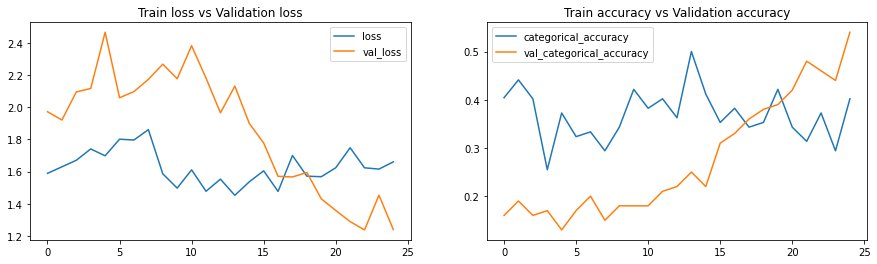

Max. Training Accuracy 0.5
Max. Validaiton Accuracy 0.5400000214576721


In [32]:
plotModelHistory(model7_history)

#### Model Type - CONV3D with more layers
#### Total params: 284,805
#### Training Accuracy - 0.5
#### Validation Accuracy - 0.54
#### Inference : Model is not giving good accuracy on traing data or validation data

# Model 8: CNN LSTM with GRU

In [38]:
n_frames = 30
num_epochs = 20
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model8 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(5), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(3))),

    TimeDistributed(Conv2D(32, make2dFilter(5), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(5), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(3))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    GRU(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model8.summary())

model8_history = model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 30, 100, 100, 16)  1216     
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 30, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 30, 33, 33, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 30, 33, 33, 32)   12832     
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 30, 33, 33, 32)  

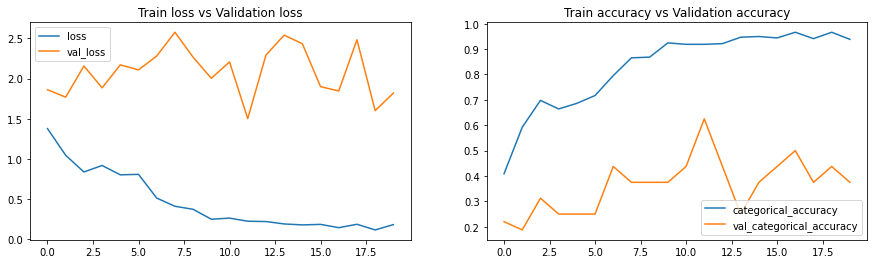

Max. Training Accuracy 0.9663865566253662
Max. Validaiton Accuracy 0.625


In [39]:
plotModelHistory(model8_history)

#### Model Type - CNN LSTM with GRU
#### Total params: 963,941
#### Training Accuracy - 0.96
#### Validation Accuracy - 0.62
#### Inference : Model is not again not giving good accuracy on vlidation data

In [14]:
from keras.applications import mobilenet

# Model 9: Transfer Learning (MobileNet) with LSTM

In [15]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model9 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model9.layers:
    layer.trainable = False

model9.add(TimeDistributed(BatchNormalization()))
model9.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model9.add(TimeDistributed(Flatten()))

model9.add(LSTM(128))
model9.add(Dropout(0.2))

model9.add(Dense(256,activation='relu'))
model9.add(Dropout(0.2))

model9.add(Dense(5, activation='softmax'))

model9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model9.summary())

model9_history = model9.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)            

2024-04-30 13:43:51.509685: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.4826 - categorical_accuracy: 0.3605 Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2024-04-3013_42_02.115991/model-00001-1.48264-0.36048-1.36221-0.51000.h5
11/11 [==============================] - 127s 12s/step - loss: 1.4826 - categorical_accuracy: 0.3605 - val_loss: 1.3622 - val_categorical_accuracy: 0.5100 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.9375 - categorical_accuracy: 0.7075
Epoch 00002: saving model to model_init_2024-04-3013_42_02.115991/model-00002-0.93749-0.70751-0.95413-0.73438.h5
11/11 [==============================] - 54s 5s/step - loss: 0.9375 - categorical_accuracy: 0.7075 - val_loss: 0.9541 - val_categorical_accuracy: 0.7344 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.7555 - categorical_accuracy: 0.7391
Epoch 00003: saving model to model_init_2024-04-3013_42_02.115991/model-0

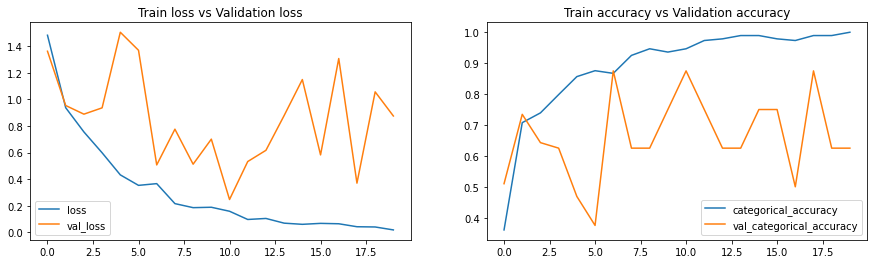

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 0.875


In [16]:
plotModelHistory(model9_history)

#### Model Type - Transfer Learning (MobileNet) with LSTM
#### Total params: 3,857,605
#### Training Accuracy - 1.00
#### Validation Accuracy - 0.87
#### Inference : Model is giving 1.00 but training data still at lower side

# Model 10: Transfer Learning (MobileNet) with LSTM ( 15 epochs + 15 frames )

In [19]:
from keras.applications import mobilenet
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 15
num_epochs = 15
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model10 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model9.layers:
    layer.trainable = False

model10.add(TimeDistributed(BatchNormalization()))
model10.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model10.add(TimeDistributed(Flatten()))

model10.add(LSTM(256))
model10.add(Dropout(0.2))

model10.add(Dense(256,activation='relu'))
model10.add(Dropout(0.2))

model10.add(Dense(5, activation='softmax'))

model10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model10.summary())

model10_history = model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 256)            

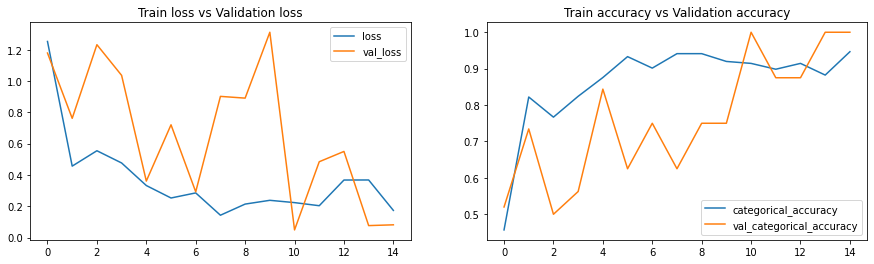

Max. Training Accuracy 0.9465240836143494
Max. Validaiton Accuracy 1.0


In [20]:
plotModelHistory(model10_history)

#### Model Type - Transfer Learning (MobileNet) with LSTM ( 15 epochs + 15 frames )
#### Total params: 4,611,781
#### Training Accuracy - 0.94
#### Validation Accuracy - 1.0
#### Inference : Model is giving by far good accuracy at this model for both Training and Validation.

# Model 11: Transfer Learning (MobileNet) with GRU

In [21]:
from keras.applications import mobilenet
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model11 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model9.layers:
    layer.trainable = False

model11.add(TimeDistributed(BatchNormalization()))
model11.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model11.add(TimeDistributed(Flatten()))

model11.add(GRU(256))
model11.add(Dropout(0.2))

model11.add(Dense(256,activation='relu'))
model11.add(Dropout(0.2))

model11.add(Dense(5, activation='softmax'))

model11.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model11.summary())

model11_history = model11.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 256)            

2024-04-30 14:25:37.037360: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


11/11 [==============================] - ETA: 0s - loss: 1.1786 - categorical_accuracy: 0.5113 Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2024-04-3013_42_02.115991/model-00001-1.17864-0.51131-0.83844-0.73000.h5
11/11 [==============================] - 150s 14s/step - loss: 1.1786 - categorical_accuracy: 0.5113 - val_loss: 0.8384 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.3295 - categorical_accuracy: 0.8775
Epoch 00002: saving model to model_init_2024-04-3013_42_02.115991/model-00002-0.32947-0.87747-1.14460-0.46875.h5
11/11 [==============================] - 55s 5s/step - loss: 0.3295 - categorical_accuracy: 0.8775 - val_loss: 1.1446 - val_categorical_accuracy: 0.4688 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.5078 - categorical_accuracy: 0.8142
Epoch 00003: saving model to model_init_2024-04-3013_42_02.115991/model-0

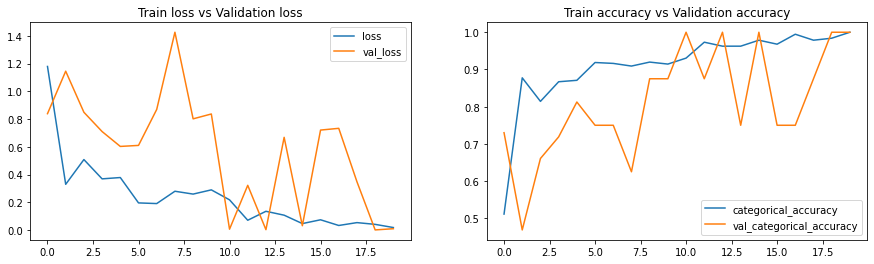

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 1.0


In [23]:
plotModelHistory(model11_history)

#### Model Type - Transfer Learning (MobileNet) with GRU
#### Total params: 4,284,613
#### Training Accuracy - 1.0
#### Validation Accuracy - 1.0
#### Inference : This is giving 100% accuracy which is more likely to get overfit or model has learn the validation data.

# Model 12 : CNN LSTM with GRU ( 20frames + 30 epochs)

In [24]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model12 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    GRU(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model12.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model12.summary())

model12_history = model12.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 20, 50, 50, 32)  

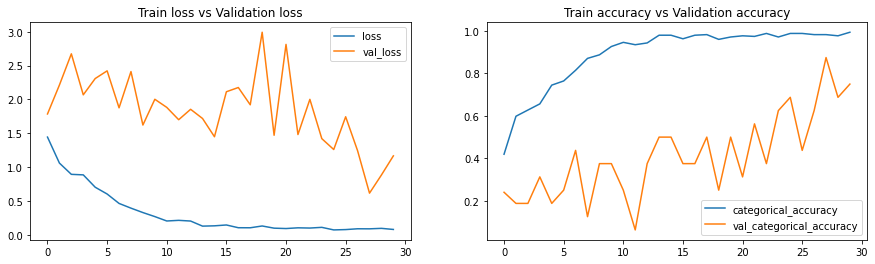

Max. Training Accuracy 0.994397759437561
Max. Validaiton Accuracy 0.875


In [25]:
plotModelHistory(model12_history)

#### Model Type - CNN LSTM with GRU ( 20frames + 30 epochs)¶
#### Total params: 2,429,28
#### Training Accuracy - 0.99
#### Validation Accuracy - 0.87
#### Inference : Getting descent accuracy with Training and validation .

# Model 13 : CNN with GRU + more layers + learning rates

In [20]:
n_frames = 30
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model13 = Sequential([
    TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Flatten()),
    GRU(128),
    Dropout(0.25),

    Dense(64, activation='relu'),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
optimiser = tf.keras.optimizers.Adam(lr=0.0001)
model13.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model13.summary())

model13_history = model13.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 30, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 30, 80, 80, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 30, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 30, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 30, 40, 40, 32)  

2024-04-30 17:49:44.029176: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.8043 - categorical_accuracy: 0.2640 Source path =  datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2024-04-3017_45_44.992905/model-00001-1.80430-0.26395-1.61452-0.18000.h5
11/11 [==============================] - 231s 22s/step - loss: 1.8043 - categorical_accuracy: 0.2640 - val_loss: 1.6145 - val_categorical_accuracy: 0.1800 - lr: 1.0000e-04
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.3710 - categorical_accuracy: 0.4269
Epoch 00002: saving model to model_init_2024-04-3017_45_44.992905/model-00002-1.37101-0.42688-1.65421-0.15625.h5
11/11 [==============================] - 115s 11s/step - loss: 1.3710 - categorical_accuracy: 0.4269 - val_loss: 1.6542 - val_categorical_accuracy: 0.1562 - lr: 1.0000e-04
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.2609 - categorical_accuracy: 0.5336
Epoch 00003: saving model to model_init_2024-04-3017_45_44.9929

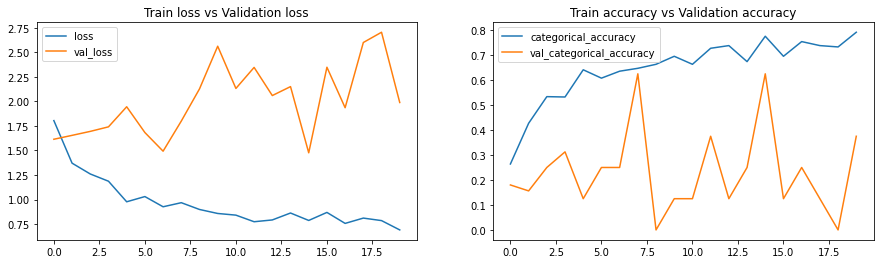

Max. Training Accuracy 0.7914438247680664
Max. Validaiton Accuracy 0.625


In [21]:
plotModelHistory(model13_history)

#### Model Type - CNN with GRU + more layers + learning rates
#### Total params: 846,309
#### Training Accuracy - 0.79
#### Validation Accuracy - 0.62
#### Inference : Not good accuracy with training and validation clearly adding more layer didn't improve the accuracy

# Model 14 : Con3D Model + Adding more layers

In [24]:
n_frames = 20
num_epochs = 20
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model14 = Sequential([
    Conv3D(16, make3dFilter(3), activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2), padding='same'),
    

    Conv3D(32, make3dFilter(3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
      

    Conv3D(64, make3dFilter(2), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    
    
    Conv3D(128, make3dFilter(2), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    
    
    Conv3D(256, make3dFilter(1), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),
    
    Conv3D(512, make3dFilter(1), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2), padding='same'),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")

optimiser = tf.keras.optimizers.Adam(lr=0.0001)
model14.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model14.summary())

model14_history = model14.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 18, 78, 78, 16)    1312      
                                                                 
 batch_normalization_28 (Bat  (None, 18, 78, 78, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 9, 39, 39, 16)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 37, 37, 32)     13856     
                                                                 
 batch_normalization_29 (Bat  (None, 7, 37, 37, 32)    128       
 chNormalization)                                                
                                                          

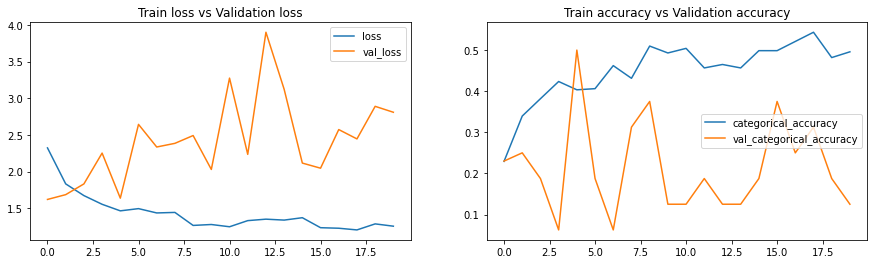

Max. Training Accuracy 0.5434173941612244
Max. Validaiton Accuracy 0.5


In [25]:
plotModelHistory(model14_history)

#### Model Type - Con3D Model + Adding more layers
#### Total params: 349,765
#### Training Accuracy - 0.54
#### Validation Accuracy - 0.5
#### Inference : Clearly adding more layers not improving the performance

# Model 15 : Conv3D + adding learning rate

In [26]:
n_frames = 20
num_epochs = 20
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

(steps_per_epoch,validation_steps)=stepsperepoch(num_train_sequences,num_val_sequences,batch_size)

    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model15 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
   # Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")

optimiser = tf.keras.optimizers.Adam(lr=0.0001)
model15.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model15.summary())

model15_history = model15.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 16, 76, 76, 16)    6016      
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 8, 38, 38, 16)    0         
 g3D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 8, 38, 38, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_16 (Conv3D)          (None, 6, 36, 36, 32)     13856     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 6, 18, 18, 32)    0         
 g3D)                                                            
                                                          

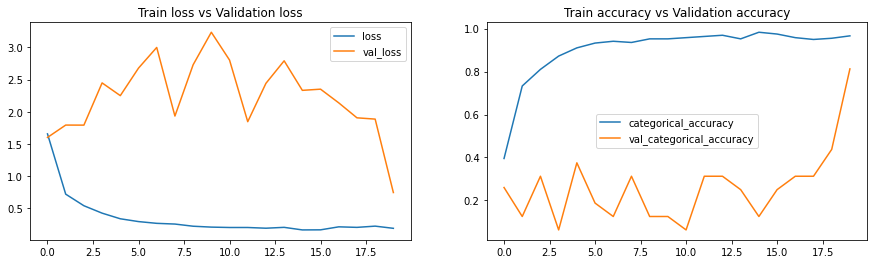

Max. Training Accuracy 0.9831932783126831
Max. Validaiton Accuracy 0.8125


In [27]:
plotModelHistory(model15_history)

#### Model Type - Con3D Model + Adding more layers
#### Total params: 2,182,309
#### Training Accuracy - 0.98
#### Validation Accuracy - 0.81
#### Inference : Descent accuracy in train and validation it seems

# Observation

##### In most of the model, There is big difference between training and validation accuracy and in transfer learning we are getting 100% accuracy which is not an optimal model hence selecting the less difference and optimal model.

##### Selecting the Model # 12 as the optimal model with below param

##### Model Type - CNN LSTM with GRU ( 20frames + 30 epochs)¶
##### Total params: 2,429,28
##### Training Accuracy - 0.99
##### Validation Accuracy - 0.87
##### Inference : Getting descent accuracy with Training and validation 